<a href="https://colab.research.google.com/github/BenWilliams2109/introduction-to-machine-learning/blob/main/comp88_lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP0088 Lab Assignment 5



## Introduction

In this week's assignment you are asked to implement a complete **multi-layer perceptron** model, including activation and loss functions, a forward pass to process data, a backwards pass to calculate gradients, mini-batch gradient descent optimisation of the weights and finally prediction from new data. There are a lot of pieces here, but don't be intimidated — *most* of them are pretty straightforward and we'll take it step by step.

For simplicity and transparency, this implementation will use just basic data structures (Python lists and dictionaries, NumPy arrays). In practice this would usually be built into a more organised class structure — we will see examples of this in week 6. If you feel particularly enthusiastic you are welcome to re-engineer these functions into something more elegant. (There are no other "further exploration" tasks this week — if you run out of things to do here, reward yourself with some rest and relaxation!)

By default the script uses the same synthetic data as the week 3 exercises, loaded from the file `week_3_data.csv`, which is downloaded in the [Setting Up](#scrollTo=4vHvSz5pReci) section. Examples of the kinds of plots that will be produced by your finished code are shown below. Plotting functionality is provided, so your output should look similar, though by default the resolution for the class maps will be significantly lower (to avoid scaling issues).

![example of completed plots](https://comp0088.github.io/assets/colab/week_5_small.jpg)


## Setting Up

As usual, this notebook makes use of the NumPy library for numerical computing and the Matplotlib library for plotting, so we need to import them.

In [1]:
import numpy as np
import numpy.random
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import pprint
import copy

# this is probably the default, but just in case
%matplotlib inline

Also as usual, fetch the shared COMP0088 lab code from the module GitHub:

In [2]:
# load lab code and resources
!git clone https://github.com/comp0088/shared.git comp0088

# at the moment this is all we care about
import comp0088.utils as utils

Cloning into 'comp0088'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 11 (delta 1), reused 7 (delta 0), pack-reused 0
Receiving objects: 100% (11/11), 10.81 KiB | 3.60 MiB/s, done.
Resolving deltas: 100% (1/1), done.


Set up some items for later use.

In [3]:
# finally, set up some items for use in later code
shared_rng = numpy.random.default_rng()

LIMITS=(-5, 5)

BLUE, ORANGE = plt.cm.tab10.colors[:2]

DATA = pd.read_csv('comp0088/week_3_data.csv')


# Task 1: Activation Functions

The MLP for these exercises will be a simple binary classifier with two input features and a single scalar (probability) output. It will use **ReLU** (rectified linear unit) activations for the intermediate hidden layers of the network and a combination of a **sigmoid** activation on the final layer with **binary cross-entropy** for calculating the loss. You will therefore need forward and derivative implementations of all three functions.

ReLU is defined as:

\begin{equation}
\text{relu}(z) =
\begin{cases}
	z \quad \text{if } z > 0 \\
	0 \quad \text{otherwise}
\end{cases}
\end{equation}

This is not differentiable at zero, but we can define a subgradient:

\begin{equation}
\text{relu}^{\prime}(z) =
\begin{cases}
	1 \quad \text{if } z > 0 \\
	0 \quad \text{otherwise}
\end{cases}
\end{equation}

The sigmoid function is:

\begin{equation}
\sigma(z) = \frac{1}{1 + e^{-z}}
\end{equation}

with derivative:

\begin{equation}
\sigma^{\prime}(z) = \sigma(z)\big(1 - \sigma(z)\big)
\end{equation}

The binary cross-entropy loss is:

\begin{equation}
L(y, \hat{y}) = -\big[ y \log \hat{y} + (1-y) \log(1 - \hat{y}) \big]
\end{equation}

with derivative:

\begin{equation}
L^{\prime} (y, \hat{y})= \frac{\hat{y} - y}{\hat{y} (1 - \hat{y})}
\end{equation}

Note that for the purposes of this implementation, all of these functions — including the loss — are to be calculated **elementwise** and should return an array of the same size and shape as the input. (For the cross-entropy functions, which have two inputs, use the shape of the `y_hat` argument.)



## 1.1 Implement forward and derivative ReLU activation

Provide implementations for the `relu` (forward) and `d_relu` (derivative) functions in the cell below.

In [65]:
def relu ( z ):
    """
    Rectified linear unit activation function.

    # Arguments
        z: a single number or numpy array

    # Returns
        r: a number or numpy array of the same dimensions
            as the input value, giving the ReLU of
            of each input value
    """
    # TODO: implement this
    #print(z)
    replace_negatives = np.vectorize(lambda x: float(x) if x > 0 else 0, otypes=[np.float])
    r = replace_negatives(z)
    #print(r)


    return r

def d_relu ( z ):
    """
    Gradient of the ReLU function

    # Arguments
        z: a single number or numpy array

    # Returns
        r: a number or numpy array of the same dimensions
            as the input value, giving the gradient
            of the ReLU function at each input value
    """

    # TODO: implement this
    replace_negatives = np.vectorize(lambda x: 1 if x > 0 else 0)
    r = replace_negatives(z)

    return r

In [64]:
z = np.array([1.2, 2, -2.5, 0, -1, 2.7])

#replace_negatives = np.vectorize(lambda x: 0 if x < 0 else x)
z = relu(np.linspace(-5,5,100))

print(z)

[0.05050505 0.15151515 0.25252525 0.35353535 0.45454545 0.55555556
 0.65656566 0.75757576 0.85858586 0.95959596 1.06060606 1.16161616
 1.26262626 1.36363636 1.46464646 1.56565657 1.66666667 1.76767677
 1.86868687 1.96969697 2.07070707 2.17171717 2.27272727 2.37373737
 2.47474747 2.57575758 2.67676768 2.77777778 2.87878788 2.97979798
 3.08080808 3.18181818 3.28282828 3.38383838 3.48484848 3.58585859
 3.68686869 3.78787879 3.88888889 3.98989899 4.09090909 4.19191919
 4.29292929 4.39393939 4.49494949 4.5959596  4.6969697  4.7979798
 4.8989899  5.        ]


## 1.2 Implement forward and derivative sigmoid activation

Provide implementations for the `sigmoid` (forward) and `d_sigmoid` (derivative) functions in the cell below.

In [5]:
def sigmoid ( z ):
    """
    Sigmoid activation function.

    # Arguments
        z: a single number or numpy array

    # Returns
        r: a number or numpy array of the same dimensions
            as the input value, giving the sigmoid (logistic)
            output for each input value
    """
    r = 1 / (1 + np.exp(-z))
    return r

def d_sigmoid ( z ):
    """
    Gradient of the sigmoid function

    # Arguments
        z: a single number or numpy array

    # Returns
        r: a number or numpy array of the same dimensions
            as the input value, giving the gradient
            of the sigmoid function at each input value
    """
    # TODO: implement this

    sig = sigmoid(z)

    r = sig * (1 - sig)

    return r

In [ ]:
z = np.array([10, 10, 2, 10, 10, 2])

np.log(z)
#d_sigmoid(z)

array([2.30258509, 2.30258509, 0.69314718, 2.30258509, 2.30258509,
       0.69314718])

## 1.3 Implement forward and derivative binary cross-entropy

Provide implementations for the `binary_crossentropy_loss` (forward) and `d_binary_crossentropy_loss` (derivative) functions in the cell below.

In [66]:
def binary_crossentropy_loss ( y, y_hat, eps=1e-10 ):
    """
    Binary cross-entropy loss for predictions, given the
    true values.

    # Arguments:
        y: a numpy array of true binary labels.
        y_hat: a numpy array of predicted labels,
            as numbers in open interval (0, 1). must have
            the same number of entries as y, but not
            necessarily identical shape
        eps: a small offset to avoid numerical problems
            when predictions are very close to 0 or 1

    # Returns:
        loss: a numpy array of individual cross-entropy
            loss values for each prediction. will be
            the same shape as y_hat irrespective of the
            shape of y
    """
    # TODO: implement this

    loss = -((y * np.log(y_hat + eps)) + (1 - y) * np.log(1 - y_hat + eps))

    return loss

def d_binary_crossentropy_loss ( y, y_hat, eps=1e-10 ):
    """
    Gradient of the cross-entropy loss for predictions, given the
    true values.

    # Arguments:
        y: a numpy array of true binary labels.
        y_hat: a numpy array of predicted labels,
            as numbers in open interval (0, 1). must have
            the same number of entries as y, but not
            necessarily identical shape
        eps: a small offset to avoid numerical problems
            when predictions are very close to 0 or 1

    # Returns:
        grad: a numpy array of individual cross-entropy
            gradient values for each prediction. will be
            the same shape as y_hat irrespective of the
            shape of y
    """
    # TODO: implement this

    grad = (y_hat - y + eps) / ( y_hat *(1 - y_hat + eps))

    return grad

## → Run Task 1

Execute the code cell below to plot the functions you wrote above. The function and its derivative will be plotted in the same axes. The results should look like the top row of plots from the figure in the [Introduction](#scrollTo=N12ZHil1_ZVN&line=7&uniqifier=1) section.


<ipython-input-65-642513520342>:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  replace_negatives = np.vectorize(lambda x: float(x) if x > 0 else 0, otypes=[np.float])
<ipython-input-66-d351f92b7b5a>:49: RuntimeWarning: divide by zero encountered in divide
  grad = (y_hat - y + eps) / ( y_hat *(1 - y_hat + eps))


[-5.         -4.8989899  -4.7979798  -4.6969697  -4.5959596  -4.49494949
 -4.39393939 -4.29292929 -4.19191919 -4.09090909 -3.98989899 -3.88888889
 -3.78787879 -3.68686869 -3.58585859 -3.48484848 -3.38383838 -3.28282828
 -3.18181818 -3.08080808 -2.97979798 -2.87878788 -2.77777778 -2.67676768
 -2.57575758 -2.47474747 -2.37373737 -2.27272727 -2.17171717 -2.07070707
 -1.96969697 -1.86868687 -1.76767677 -1.66666667 -1.56565657 -1.46464646
 -1.36363636 -1.26262626 -1.16161616 -1.06060606 -0.95959596 -0.85858586
 -0.75757576 -0.65656566 -0.55555556 -0.45454545 -0.35353535 -0.25252525
 -0.15151515 -0.05050505  0.05050505  0.15151515  0.25252525  0.35353535
  0.45454545  0.55555556  0.65656566  0.75757576  0.85858586  0.95959596
  1.06060606  1.16161616  1.26262626  1.36363636  1.46464646  1.56565657
  1.66666667  1.76767677  1.86868687  1.96969697  2.07070707  2.17171717
  2.27272727  2.37373737  2.47474747  2.57575758  2.67676768  2.77777778
  2.87878788  2.97979798  3.08080808  3.18181818  3

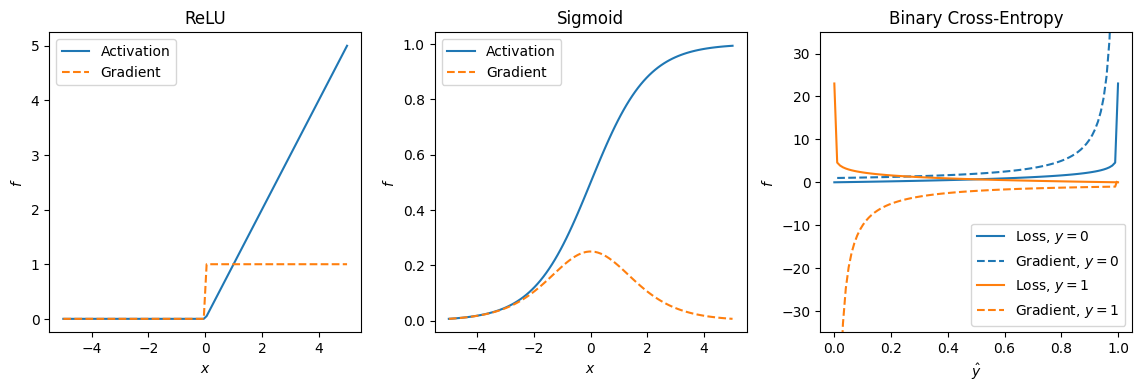

In [67]:
fig = plt.figure(figsize=(11.5, 4))
axs = fig.subplots(ncols=3)

xx = np.linspace(-5,5,100)
yy = np.linspace(0,1,100)
y0 = np.zeros(100)
y1 = np.ones(100)

aa = relu(xx)
print(xx)
print(aa)
dd = d_relu(xx)
if (aa is None) and (dd is None):
  utils.plot_unimplemented(axs[0], 'ReLU')
else:
  if aa is not None: axs[0].plot(xx, aa, color=BLUE, label='Activation')
  if dd is not None: axs[0].plot(xx, dd, color=ORANGE, linestyle='dashed', label='Gradient')
  axs[0].set_title('ReLU')
  axs[0].set_xlabel('$x$')
  axs[0].set_ylabel('$f$')
  axs[0].legend()

aa = sigmoid(xx)
dd = d_sigmoid(xx)
if (aa is None) and (dd is None):
  utils.plot_unimplemented(axs[1], 'Sigmoid')
else:
  if aa is not None: axs[1].plot(xx, aa, color=BLUE, label='Activation')
  if dd is not None: axs[1].plot(xx, dd, color=ORANGE, linestyle='dashed', label='Gradient')
  axs[1].set_title('Sigmoid')
  axs[1].set_xlabel('$x$')
  axs[1].set_ylabel('$f$')
  axs[1].legend()

ll0 = binary_crossentropy_loss(y0, yy)
ll1 = binary_crossentropy_loss(y1, yy)
dd0 = d_binary_crossentropy_loss(y0, yy)
dd1 = d_binary_crossentropy_loss(y1, yy)

if (ll0 is None) and (ll1 is None) and (dd0 is None) and (dd1 is None):
  utils.plot_unimplemented(axs[2], 'Binary Cross-Entropy')
else:
  if ll0 is not None: axs[2].plot(yy, ll0, color=BLUE, label='Loss, $y=0$')
  if dd0 is not None: axs[2].plot(yy, dd0, color=BLUE, linestyle='dashed', label='Gradient, $y=0$')
  if ll1 is not None: axs[2].plot(yy, ll1, color=ORANGE, label='Loss, $y=1$')
  if dd1 is not None: axs[2].plot(yy, dd1, color=ORANGE, linestyle='dashed', label='Gradient, $y=1$')
  axs[2].set_title('Binary Cross-Entropy')
  axs[2].set_xlabel('$\\hat{y}$')
  axs[2].set_ylabel('$f$')
  axs[2].set_ylim(-35,35)
  axs[2].legend(loc='lower right')

fig.tight_layout(pad=1)


# Task 2: Build a neural network

The underlying data structures for the multi-layer perceptron are **layers**, which here will be represented by a Python dictionary, and the whole network, which will just be a Python list of layers. Each layer performs a weighted sum of its inputs followed by a non-linear activation.


## 2.1 Create and initialise a single network layer

Implement the function `init_layer` in the code cell below.

The data structure returned by this function should be a Python dictionary with the following keys and values:

* `W`: a weights matrix of shape `fan_in` $\times$ `fan_out`. We are going to be using ReLU activation for the hidden layers, so you should use **He initialisation** for the weight values, drawing from a **uniform** distribution over the range: $$\Bigg(-\sqrt{\frac{6}{\text{fan_in}}} \, , \; \sqrt{\frac{6}{\text{fan_in}}} \Bigg)$$
* `b`:  a bias vector of length `fan_out`. Biases can be initialised to 0
* `act`: the name of the specified activation function, i.e. this should store the value passed in the argument `act`
* `shape`: a text string describing the shape mapping of the layer. This will be used to print information about a created MLP; you can format it anyway you like.

Note that the dictionary keys (and all the others that will be added later) are just text strings.

First is create dictionary for 1 layer, next is list of dictionaries


In [26]:
def init_layer ( fan_in, fan_out, act, rng ):
  """
  Create a single neural network layer.

  # Arguments
      fan_in: the number of incoming connections
      fan_out: the number of outgoing connections
      act: name of the activation function for the
          layer, either "sigmoid" or "relu"
      rng: an instance of numpy.random.Generator
          from which to draw random numbers

  # Returns
      layer: a dict holding the layer contents, with
          keys 'W', 'b', 'shape' and 'act'.
          (See the description above for full details.)
  """
  # TODO: implement this

  limits = (-np.sqrt(6/fan_in), np.sqrt(6/fan_out))

  layer = {
      "W" : utils.make_random(fan_in*fan_out, limits, rng, count=1).reshape((fan_in, fan_out)),
      "b" : np.zeros(fan_out),
      "act" : act,
      "shape" : "The shape of the mapping layer is {0} by {1}".format(fan_in, fan_out),
  }

  return layer

In [20]:
init_layer(5, 5, "sigmoid", shared_rng)

{'w': array([[-0.58887016, -0.8298445 , -0.20945106, -1.00122203,  0.30493393],
        [-0.98798234, -0.23772947,  0.83493718, -0.14521893, -0.84700882],
        [ 0.66696285, -0.21406575, -0.59988599, -0.05982659, -0.34268031],
        [ 0.20165062, -0.65371002, -0.11226147,  0.07120495,  0.77866862],
        [ 0.01825847,  0.29909673,  0.2707216 , -0.01225147,  0.17574505]]),
 'b': array([0., 0., 0., 0., 0.]),
 'act': 'sigmoid',
 'shape': 'The shape of the mapping layer is 5 by 5'}

In [15]:
 b = np.zeros(5)
 b

array([0., 0., 0., 0., 0.])

## 2.2 Create and initialise a complete network

Implement the `init_mlp` function in the code cell below to build a list of individual layers to match a simple specification. The layers themselves are just dictionaries returned by `init_layer`.

Iterate over the list of tuples in `spec` and create a layer for each one except the last, setting the `fan_out` of each layer as the `fan_in` of the next. (Use the activation from the input tuple; the last one will have an activation of `None`.)


In [24]:
def init_mlp ( spec, rng ):
  """
  Build a neural network according to the
  given specification.

  # Arguments
      spec: an iterable of tuples (fan_in, act)
          specifying the configuration of the network layers.
          there must be at least 2 elements; the last is only
          used to determine output size of the layer before,
          it does not create a layer of its own
      rng: an instance of numpy.random.Generator
          from which to draw random numbers

  # Returns
      mlp: a list of layer dicts
  """
  assert(len(spec) > 1)

  mlp = []

  for i in range(0, len(spec)-1):

    mlp.append(init_layer(spec[i][0], spec[i+1][0], spec[i][1], rng))

  # TODO: implement this
  return mlp

In [22]:
test = ((2, 'relu'), (50, 'relu'), (50, 'sigmoid'), (1, None))



(2, 50)
(50, 50)
(50, 1)


## → Run Task 2

Run the cell below to perform a simple test of your functions above. Note that this is pretty superficial as the code isn't doing very much yet.

In [29]:
nn = init_mlp( ((2, 'relu'), (50, 'relu'), (50, 'sigmoid'), (1, None)), shared_rng )
assert(len(nn)==3)
assert('shape' in nn[0])
assert('act' in nn[0])
assert('W' in nn[0])
assert('b' in nn[0])
pprint.pprint( [ (layer['shape'], [layer['W'].shape, layer['b'].shape], layer['act']) for layer in nn] )
print(f'\nMean of middle layer weights (should be close to zero): {np.mean(nn[1]["W"]):.3f}')

[('The shape of the mapping layer is 2 by 50', [(2, 50), (50,)], 'relu'),
 ('The shape of the mapping layer is 50 by 50', [(50, 50), (50,)], 'relu'),
 ('The shape of the mapping layer is 50 by 1', [(50, 1), (1,)], 'sigmoid')]

Mean of middle layer weights (should be close to zero): -0.006


# Task 3: Perform a forward pass

In the forward pass through the network, layers receive input data and produce outputs, storing information they will need to calculate gradients. The outputs from each layer become the inputs to the next.


## 3.1 Perform a forward pass through a single network layer

Implement the `layer_forward` function in the code cell below to perform the forward pass through one layer.

The forward pass computes

\begin{align}
\mathbf{Z} &= \mathbf{XW} \\
\mathbf{A} &= \text{activation}(\mathbf{Z})
\end{align}

You will need the input data, linear combination and output for the backwards pass, so store these in the `layer` dictionary with the keys `X`, `Z` and `A`, respectively.


In [69]:
def layer_forward ( layer, X ):
    """
    Run a forward pass of data through a layer, storing
    intermediate values in the layer dict.

    # Arguments
        layer: a layer dict as created by init_layer
        X: the input data to the layer, a matrix
            where the columns are features and the
            rows are samples. feature count must
            match the layer's fan_in

    # Returns
        A: the layer's output activations, a matrix where the
            columns are (fan_out) features and the rows are
            samples
    """
    # TODO: implement this
    layer["X"] = X
    layer["Z"] = np.matmul(X, layer["W"]) + layer["b"]

    if layer["act"] == "sigmoid":
        layer["A"] = sigmoid(layer["Z"])
    elif layer["act"] == "relu":
        layer["A"] = relu(layer["Z"])

    return layer["A"]

## 3.2 Perform a forward pass through a whole network

Implement the `mlp_forward` function in the code cell below to perform a forward pass through the whole network. This should just iterate over the layers in turn, calling `layer_forward` for each one. The input to the first layer is the network input data argument `X`, while the input for subsequent layers is the output from the layer before.

In [71]:
def mlp_forward ( mlp, X ):
    """
    Run a forward pass through a whole neural net.

    # Arguments
        mlp: a list of layer dicts, as created by init_mlp
        X: the input data to the network, a matrix
            where the columns are features and the
            rows are samples. feature count must
            match the first layer's fan_in

    # Returns
        A: the output activations of the final network layer
    """
    # TODO: implement this

    layer_forward(mlp[0], X)

    for i in range(1, len(mlp)):
        layer_forward(mlp[i], mlp[i-1]["A"])

    return mlp[-1]["A"]

## → Run Task 3

Run the cell below to perform a simple test of your forward pass processing. As with Task 2, the checks here are pretty rudimentary — the functions will be more thoroughly exercised later on.

In [72]:
# build a simple (non-random) network and some test data
# we'll reuse this later, so make it a function
def make_test ():
  nn = [{'W': np.array([[ 1.,0.], [0.,-1.]]),
    'b': np.array([1., 0.]),
    'shape': '1->2',
    'act': 'relu'},
  {'W': np.array([[ 1.], [-1.]]),
    'b': np.array([1.]),
    'shape': '2->1',
    'act': 'sigmoid'}]
  X = np.eye(2)

  return nn, X

nn1, X1 = make_test()
A1 = mlp_forward(nn1, X1)

# look at the updated version
display(nn1)

# check some keys and values are what we expect
assert('X' in nn1[0])
assert(np.allclose(X1, nn1[0]['X']))

assert('A' in nn1[0])
assert(np.allclose(nn1[0]['A'], np.array([[2., 0.], [1., 0.]])))

assert('X' in nn1[0])
assert(np.allclose(nn1[0]['A'], nn1[1]['X']))

assert('Z' in nn1[1])
assert(np.allclose(nn1[1]['Z'], np.array([[3], [2]])))

assert(np.allclose(A1, np.array([[0.95257413], [0.88079708]])))

<ipython-input-65-642513520342>:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  replace_negatives = np.vectorize(lambda x: float(x) if x > 0 else 0, otypes=[np.float])


[{'W': array([[ 1.,  0.],
         [ 0., -1.]]),
  'b': array([1., 0.]),
  'shape': '1->2',
  'act': 'relu',
  'X': array([[1., 0.],
         [0., 1.]]),
  'Z': array([[ 2.,  0.],
         [ 1., -1.]]),
  'A': array([[2., 0.],
         [1., 0.]])},
 {'W': array([[ 1.],
         [-1.]]),
  'b': array([1.]),
  'shape': '2->1',
  'act': 'sigmoid',
  'X': array([[2., 0.],
         [1., 0.]]),
  'Z': array([[3.],
         [2.]]),
  'A': array([[0.95257413],
         [0.88079708]])}]

# Task 4: Perform a backward pass

In the backward pass through the network, layers receive the downstream loss gradient (with respect to their output activations) and calculate their loss gradients with respect to their weights, bias and inputs, storing these for subsequent learning. The gradients with respect to the inputs from each layer are then propagated back as the downstream gradients for the previous layer.

## 4.1 Perform a backward pass through a single network layer

Implement the `layer_backward` function in the code cell below to perform a backward pass through a single layer.

The gradients propagate backwards by multiplication. For the activations, the derivative evaluation and multiplication both occur **elementwise**:

\begin{equation}
\nabla_{\mathbf{Z}} = \nabla_{\mathbf{A}} \times \text{activation}^{\prime}(\mathbf{Z})
\end{equation}

For the weights and inputs, the calculation involves inner products, so we can express it using matrix multiplication, taking care that the right product winds up in the right place in the matrix. The relevant expressions are:

\begin{align}
\nabla_{\mathbf{X}} &= \nabla_{\mathbf{Z}} \mathbf{W}^{\mathsf{T}} \\
\nabla_{\mathbf{W}} &= \mathbf{X}^{\mathsf{T}} \nabla_{\mathbf{Z}}
\end{align}

For the bias term, there is no input dependence, and so the gradient vector is $\mathbf{1} \cdot \nabla_{\mathbf{Z}}$ (i.e, the columnwise sum of $\nabla_{\mathbf{Z}}$).

Save all the gradients in the dictionary with keys `dA`, `dZ`, `dW`, `db` and `dX`, returning the latter.

**NB**: while this function can be implemented in just a few lines of code, there's a lot going on here, so it's worth taking some time to understand it. This is the core of the backpropagation process that makes it possible to train a neural networks.


In [ ]:
def layer_backward ( layer, dA ):
    """
    Run a backward pass of gradients through a layer, storing
    computed values in the layer dict. The forward pass must
    have been performed first.

    # Arguments
        layer: a layer dict as created by init_layer
        dA: the gradients of the loss with respect to the
            forward pass activations. a matrix the same shape
            as those previously computed activations.

    # Returns
        dX: the gradients of the loss with respect to the
            layer inputs from the forward pass
    """
    # TODO: implement this
    return None

## 4.2 Perform a backward pass through a whole network

Implement the `mlp_backward` function in the code cell below to perform a backward pass through the complete network.

Like the forward pass, the backward pass simply involves iterating through the network calling `layer_backward` on each layer. Remember to traverse the list in reverse, and pass the gradient returned by each layer to the one before it.

In [ ]:
def mlp_backward ( mlp, d_loss ):
    """
    Backpropagate gradients through the whole neural net.
    The forward pass must have been performed first.

    # Arguments
        mlp: a list of layer dicts, as created by init_mlp
        d_loss: the gradients of the loss at the final
            layer output, a matrix the same shape
            as previously computed activations.

    # Returns
        None
    """
    # TODO: implement this
    return None

## → Run Task 4

Run the cell below to perform a simple test of your backward pass processing. Once again, this is not an exhaustive test, but it should present a reasonable first hurdle.


In [ ]:
# remake test network each time since the passes modify it
nn1, X1 = make_test()
A1 = mlp_forward(nn1, X1)

# run backward pass with final gradients all set to 1
dA1 = np.ones_like(A1)
mlp_backward(nn1, dA1)

# print the updated network
display(nn1)

# check some keys and values are what we expect
assert('dA' in nn1[1])
assert(np.allclose(dA1, nn1[1]['dA']))

assert('dZ' in nn1[1])
assert(np.allclose(nn1[1]['dZ'], np.array([[0.04517666], [0.10499359]])))

assert('dW' in nn1[1])
assert(np.allclose(nn1[1]['dW'], np.array([[0.1953469], [0.]])))

assert('dX' in nn1[1])
assert('dA' in nn1[0])
assert(np.allclose(nn1[0]['dA'], nn1[1]['dX']))



# Task 5: Update the network weights

We'll train the network using vanilla gradient descent, simply adjusting the weights and bias at each iteration by a fraction of the gradient:

\begin{align}
\mathbf{W} &\gets \mathbf{W} - \alpha \nabla_{\mathbf{W}} \\
\mathbf{b} &\gets \mathbf{b} - \alpha \nabla_{\mathbf{b}}
\end{align}

where $\alpha$ is the learning rate.


## 5.1 Update the weights for a single network layer

Implement the `layer_update` function in the cell below to update the weights and bias of a single layer by a fraction (`lr`) of the gradients calculated during the backward pass.

Remember to update the values assigned to the keys `W` and `b` in the layer dictionary.

In [ ]:
def layer_update ( layer, lr ):
    """
    Update layer weights & biases according to the previously
    computed gradients. Forward and backward passes
    must both have been performed.

    # Arguments
        layer: a layer dict as created by init_layer
        lr: the learning rate

    # Returns
        None
    """
    # TODO: implement this
    return None

## 5.2 Update the weights for a whole network

Implement the `mlp_update` function below to update all the weights and biases in a network. Once again, this just involves iterating over the layers and calling `layer_update` on each.

In what order should this take place?

In [ ]:
def mlp_update ( mlp, lr ):
    """
    Update all network weights & biases according to the
    previously computed gradients. Forward and backward passes
    must both have been performed.

    # Arguments
        mlp: a list of layer dicts, as created by init_mlp
        lr: the learning rate

    # Returns
        None
    """
    # TODO: implement this
    pass

## → Run Task 5

In [ ]:
# remake & rerun test network each time since the passes modify it
nn1, X1 = make_test()
A1 = mlp_forward(nn1, X1)
dA1 = np.ones_like(A1)
mlp_backward(nn1, dA1)

# duplicate before updating so we can compare before & after
nn2 = copy.deepcopy(nn1)

LR = 0.1
mlp_update( nn2, LR )
display(nn2)

# check params have been updated as expected
assert(np.allclose(nn2[0]['W'], nn1[0]['W'] - LR * nn1[0]['dW']))
assert(np.allclose(nn2[0]['b'], nn1[0]['b'] - LR * nn1[0]['db']))
assert(np.allclose(nn2[1]['W'], nn1[1]['W'] - LR * nn1[1]['dW']))
assert(np.allclose(nn2[1]['b'], nn1[1]['b'] - LR * nn1[1]['db']))

# Task 6: Train the network

We're going to train the network using **mini-batch gradient descent**. This means iterating over the training data in bite size chunks, and for each chunk executing a forward pass, then a backward pass, then a weights update.

One complete run through all the mini-batches in the training set is known as an **epoch**.


## 6.1 Train the network on a single mini-batch of data

Implement the `mlp_minibatch` function in the cell below to do a single training iteration of a network with a single mini-batch of data.

The data passed in `X` and `y` is just the single chunk, so you can pass it straight to the network.

The output of `mlp_forward` is from the final layer sigmoid, representing the probabilistic predictions $\hat{\mathbf{y}}$. You will need to use this together with the ground truth labels `y` to calculate the cross entropy loss and also the loss gradient. The latter should then be propagated back through the network, and the former should be returned. (Divide by the number of samples to get the mean loss.)

In [ ]:
def mlp_minibatch ( mlp, X, y, lr ):
    """
    Fit a neural network to a single mini-batch
    of training data.

    # Arguments
        mlp: a list of layer dicts, as created by init_mlp
        X: an array of sample data, where rows are samples
            and columns are features. feature dimension must
            match the input dimension of mlp.
        y: vector of binary class labels corresponding to the
            samples, must be same length as number of rows in X
        lr: the learning rate

    # Returns
        loss: the mean training loss over the minibatch
    """
    assert(X.shape[0] == len(y))
    assert(X.shape[-1] == mlp[0]['W'].shape[0])

    # TODO: implement this
    return None

## 6.2 Train the network for one complete epoch

Implement `mlp_epoch` in the code cell below to train the network on all the provided data, one mini-batch at a time.

This is basically an exercise in data management, splitting the data and labels into matched chunks to pass to `mlp_minibatch`. You may find the [`permutation`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.permutation.html) function useful to randomise the order of samples each epoch.



In [ ]:
def mlp_epoch ( mlp, X, y, batch, lr, rng ):
    """
    Fit a neural network for one epoch -- ie, a single
    pass through the data in minibatches of specified size.

    # Arguments
        mlp: a list of layer dicts, as created by init_mlp
        X: an array of sample data, where rows are samples
            and columns are features. feature dimension must
            match the input dimension of mlp.
        y: vector of binary class labels corresponding to the
            samples, must be same length as number of rows in X
        batch: the size of minibatches to train
        lr: the learning rate
        rng: an instance of numpy.random.Generator
            from which to draw random numbers

    # Returns
        loss: the mean training loss over the whole dataset
    """
    # TODO: implement this
    return None

## 6.3 Train the network for multiple epochs

Implement `mlp_train` in the code cell below to train a network for multiple epochs. This should just call `mlp_epoch` the requested number of times, recording the loss history as it goes.

In [ ]:
def mlp_train ( mlp, X, y, batch, epochs, lr, rng ):
    """
    Fit a neural network iteratively for multiple
    epochs.

    # Arguments
        mlp: a list of layer dicts, as created by init_mlp
        X: an array of sample data, where rows are samples
            and columns are features. feature dimension must
            match the input dimension of mlp.
        y: vector of binary class labels corresponding to the
            samples, must be same length as number of rows in X
        batch: the size of minibatches to train
        epochs: number of epochs to train
        lr: the learning rate
        rng: an instance of numpy.random.Generator
            from which to draw random numbers

    # Returns
        loss: a list of the mean training loss at each epoch
    """
    # TODO: implement this
    return None


(Note that there isn't a "Run Task 6" cell here — we defer this to the next section.)

# Task 7: Test the network

The `mlp_forward` function already allows you to run test data through a network, but it is useful also to be able to generate class labels rather than probabilities.


## 7.1 Make predictions

Implement the `mlp_predict` function to make predictions on binary class from a neural net. (This will be used in the testing section below to plot a classification map.)

In [ ]:
def mlp_predict ( mlp, X, thresh=0.5 ):
    """
    Make class predictions from a neural network.

    # Arguments
        mlp: a list of layer dicts, as created by init_mlp
        X: an array of test data, where rows are samples
            and columns are features. feature dimension must
            match the input dimension of mlp.
        thresh: the decision threshold

    # Returns
        y_hat: a vector of predicted binary labels for X
    """
    # TODO: implement this
    return None

## 7.2 Train and test your classifier

Run the cell below to use your functions above to build a neural net, train it on our loaded data, test it and plot the results.

There are some configuration variables at the top of the cell which may significantly affect how the neural net behaves (and also how long this all takes to run). Try playing around with these and seeing what happens.

In [ ]:
# configure

# model structure
# input and output sizes are predefined for this task,
# so here we just specify the number of neurons in each
# hidden layer
HIDDEN = (4, 3)

# training hyperparameters
BATCH = 1
EPOCHS = 100
LR = 1e-2

# number of samples in training set
NUM_SAMPLES = 50

# plotting resolution for the classification map
RESOLUTION = 20

# --------

# select training data
X = DATA[['X1','X2']].values[:NUM_SAMPLES,:]
y = DATA['Binary'].values[:NUM_SAMPLES]

fig = plt.figure(figsize=(11.5, 4))
axs = fig.subplots(ncols=3)

# build model
layers = ((2, 'relu'),) + tuple((n, 'relu') for n in HIDDEN[:-1]) + ((HIDDEN[-1], 'sigmoid'), (1, None))
nn = init_mlp(layers, shared_rng)

if nn is None:
  utils.plot_unimplemented(axs[0], 'Training Loss')
  utils.plot_unimplemented(axs[1], f'{len(layers)-1}-Layer MLP')
  utils.plot_unimplemented(axs[2], 'Output Activations')
else:
  # train it
  loss = mlp_train(nn, X, y, BATCH, EPOCHS, LR, shared_rng)
  if loss is None:
    utils.plot_unimplemented(axs[0], 'Training Loss')
    utils.plot_unimplemented(axs[1], f'{len(layers)-1}-Layer MLP')
    utils.plot_unimplemented(axs[2], 'Output Activations')
  else:
    axs[0].plot(loss)
    axs[0].set_title('Training Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Mean Binary Cross-Entropy')

    utils.plot_classification_map(axs[1], lambda z: mlp_predict(nn, z), X, y,
                                  resolution=RESOLUTION, limits=LIMITS,
                                  title=f'{len(layers)-1}-Layer MLP')

    # everything from the last forward pass is stashed in the network
    # so we can pull out the activations from the last layer to plot
    im = nn[-1]['A'].reshape((RESOLUTION,RESOLUTION))
    axs[2].imshow(im.T, origin='lower', extent=LIMITS * 2, cmap='Greens')
    axs[2].set_title('Output Activations')
    axs[2].set_xlabel('$x_1$')
    axs[2].set_ylabel('$x_2$')

fig.tight_layout(pad=1)